In [3]:
# Librerías estándar
import os
import glob
import random

# Librerías científicas y de análisis de datos
import pandas as pd

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Persistencia del modelo
import joblib

In [4]:
# Configuración de rutas usando config.py
import os
import sys
from pathlib import Path

# Agregar raíz del proyecto al path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importar configuración
from config import config

# Usar rutas de configuración
current_dir = str(Path.cwd())
base_dir = str(config.DOCUMENTOS_TXT_DIR)

print(f"Directorio del proyecto: {project_root}")
print(f"Directorio de datos (TXTs): {base_dir}")

# Función para detectar clases automáticamente basándose en carpetas
def detectar_clases_automaticamente(base_path):
    """
    Detecta automáticamente las clases basándose en las carpetas dentro del directorio base.
    Retorna una lista con los nombres de las clases encontradas.
    """
    clases = []
    if os.path.exists(base_path):
        for item in os.listdir(base_path):
            item_path = os.path.join(base_path, item)
            if os.path.isdir(item_path):
                clases.append(item)
    else:
        print(f"❌ El directorio {base_path} no existe.")
        print(f"\nEstructura esperada:")
        print(f"  {base_path}/")
        print(f"    ├── clase1/")
        print(f"    │   ├── documento1.txt")
        print(f"    │   └── documento2.txt")
        print(f"    ├── clase2/")
        print(f"    └── ...")
        print(f"\nPara crear esta estructura:")
        print(f"  1. Coloca tus PDFs en datos/documentos-original/clase1/, clase2/, etc.")
        print(f"  2. Ejecuta: python scripts/procesar_pdfs.py")
        print(f"  3. Ejecuta: python scripts/mover_txts.py")
        return []

    return sorted(clases)

# Detectar clases disponibles
clases_disponibles = detectar_clases_automaticamente(base_dir)
print(f"Clases detectadas automáticamente: {clases_disponibles}")

# Verificar que existan clases
if not clases_disponibles:
    print(f"\n❌ No se encontraron carpetas de clases en: {base_dir}")
else:
    print(f"✅ Total de clases encontradas: {len(clases_disponibles)}")


Directorio del proyecto: c:\Users\liags\Desktop\Modelo
Directorio de datos (TXTs): c:\Users\liags\Desktop\Modelo\datos\documentos-txt
Clases detectadas automáticamente: ['alta-autonomo', 'alta-terceros', 'ccaa', 'certificado-aeat', 'certificado-atc', 'certificado-ss', 'cif', 'cumplimiento-plazos-pagos', 'dni', 'een', 'eliminar', 'escritura', 'facturas', 'grado-discapacidad', 'iae', 'informe-vida-laboral', 'inventario', 'irpf', 'ita', 'justificante-bancario', 'm200', 'memoria-actuacion-justificativa', 'memoria-economica', 'otros', 'solicitud']
✅ Total de clases encontradas: 25


In [5]:
# Función para cargar datos desde carpetas locales
def cargar_datos_local(base_path, extensiones=['.txt']):
    """
    Carga datos desde carpetas locales donde cada carpeta representa una clase.
    
    Args:
        base_path (str): Ruta base donde están las carpetas de clases
        extensiones (list): Lista de extensiones de archivo a procesar
    
    Returns:
        list: Lista de diccionarios con 'texto' y 'etiqueta'
    """
    data = []
    archivos_procesados = 0
    archivos_error = 0
    
    # Detectar clases automáticamente
    clases = detectar_clases_automaticamente(base_path)
    
    for clase in clases:
        clase_path = os.path.join(base_path, clase)
        print(f"\nProcesando clase: {clase}")
        
        # Buscar archivos con las extensiones especificadas
        archivos_clase = []
        for ext in extensiones:
            patron = os.path.join(clase_path, f"*{ext}")
            archivos_clase.extend(glob.glob(patron))
        
        # Filtrar archivos README
        archivos_clase = [f for f in archivos_clase if not os.path.basename(f).upper().startswith('README')]
        
        print(f"  Archivos encontrados: {len(archivos_clase)}")
        
        # Procesar cada archivo
        for archivo_path in archivos_clase:
            try:
                with open(archivo_path, 'r', encoding='utf-8', errors='ignore') as f:
                    texto = f.read().strip()
                
                if texto:  # Solo agregar si el texto no está vacío
                    data.append({
                        'texto': texto,
                        'etiqueta': clase,
                        'archivo': os.path.basename(archivo_path)
                    })
                    archivos_procesados += 1
                else:
                    print(f"  Archivo vacío omitido: {os.path.basename(archivo_path)}")
                    
            except Exception as e:
                print(f"  Error leyendo {os.path.basename(archivo_path)}: {e}")
                archivos_error += 1
    
    print(f"\nResumen de carga:")
    print(f"  Archivos procesados exitosamente: {archivos_procesados}")
    print(f"  Archivos con error: {archivos_error}")
    
    return data

# Cargar los datos
data = cargar_datos_local(base_dir)

# Crear DataFrame
df = pd.DataFrame(data)

if len(df) > 0:
    # Mostrar distribución de etiquetas
    cantidades = df["etiqueta"].value_counts()
    print("\nDistribución de etiquetas (cantidad):")
    print(cantidades)
    
    # Mostrar muestra aleatoria de archivos
    muestra = df.sample(min(5, len(df)))
    print("\nMuestra de archivos cargados:")
    for idx, row in muestra.iterrows():
        print(f"  Archivo: {row['archivo']} - Clase: {row['etiqueta']}")
    
    # Verificar textos vacíos
    vacios = df["texto"].isna().sum() + (df["texto"] == "").sum()
    print(f"\nDocumentos con texto vacío o nulo: {vacios}")
else:
    print("No se cargaron datos. Verifica la estructura de carpetas y archivos.")
    print(f"Directorio esperado: {base_dir}")


Procesando clase: alta-autonomo
  Archivos encontrados: 10

Procesando clase: alta-terceros
  Archivos encontrados: 10

Procesando clase: ccaa
  Archivos encontrados: 10

Procesando clase: certificado-aeat
  Archivos encontrados: 10

Procesando clase: certificado-atc
  Archivos encontrados: 10

Procesando clase: certificado-ss
  Archivos encontrados: 10

Procesando clase: cif
  Archivos encontrados: 7

Procesando clase: cumplimiento-plazos-pagos
  Archivos encontrados: 10

Procesando clase: dni
  Archivos encontrados: 15

Procesando clase: een
  Archivos encontrados: 12

Procesando clase: eliminar
  Archivos encontrados: 20

Procesando clase: escritura
  Archivos encontrados: 12

Procesando clase: facturas
  Archivos encontrados: 20

Procesando clase: grado-discapacidad
  Archivos encontrados: 2

Procesando clase: iae
  Archivos encontrados: 10

Procesando clase: informe-vida-laboral
  Archivos encontrados: 20

Procesando clase: inventario
  Archivos encontrados: 10

Procesando clase:

Entrenando modelo con 25 clases: ['alta-autonomo', 'alta-terceros', 'ccaa', 'certificado-aeat', 'certificado-atc', 'certificado-ss', 'cif', 'cumplimiento-plazos-pagos', 'dni', 'een', 'eliminar', 'escritura', 'facturas', 'grado-discapacidad', 'iae', 'informe-vida-laboral', 'inventario', 'irpf', 'ita', 'justificante-bancario', 'm200', 'memoria-actuacion-justificativa', 'memoria-economica', 'otros', 'solicitud']

Distribución original:
etiqueta
otros                              26
facturas                           20
eliminar                           20
informe-vida-laboral               20
dni                                15
memoria-economica                  14
justificante-bancario              12
een                                12
escritura                          12
iae                                10
memoria-actuacion-justificativa    10
ita                                10
inventario                         10
alta-autonomo                      10
alta-terceros         

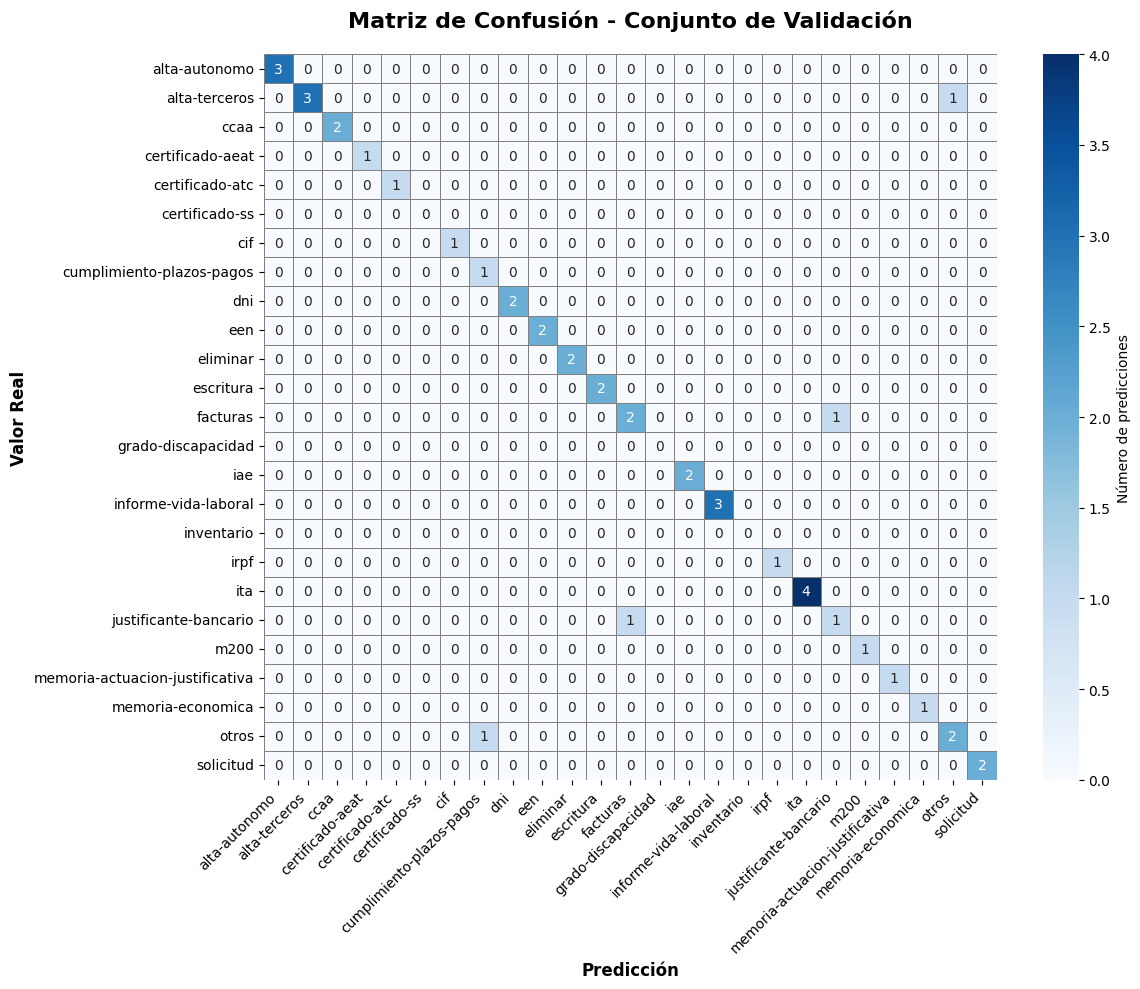


📈 ANÁLISIS DETALLADO POR CLASE

alta-autonomo:
  Total muestras: 3
  Aciertos: 3
  Tasa de acierto: 100.0%

alta-terceros:
  Total muestras: 4
  Aciertos: 3
  Tasa de acierto: 75.0%
  Confundido con: ['otros']

ccaa:
  Total muestras: 2
  Aciertos: 2
  Tasa de acierto: 100.0%

certificado-aeat:
  Total muestras: 1
  Aciertos: 1
  Tasa de acierto: 100.0%

certificado-atc:
  Total muestras: 1
  Aciertos: 1
  Tasa de acierto: 100.0%

cif:
  Total muestras: 1
  Aciertos: 1
  Tasa de acierto: 100.0%

cumplimiento-plazos-pagos:
  Total muestras: 1
  Aciertos: 1
  Tasa de acierto: 100.0%

dni:
  Total muestras: 2
  Aciertos: 2
  Tasa de acierto: 100.0%

een:
  Total muestras: 2
  Aciertos: 2
  Tasa de acierto: 100.0%

eliminar:
  Total muestras: 2
  Aciertos: 2
  Tasa de acierto: 100.0%

escritura:
  Total muestras: 2
  Aciertos: 2
  Tasa de acierto: 100.0%

facturas:
  Total muestras: 3
  Aciertos: 2
  Tasa de acierto: 66.7%
  Confundido con: ['justificante-bancario']

iae:
  Total muestras

In [6]:
# Verificar que tenemos datos suficientes para entrenar
if len(df) == 0:
    print("Error: No hay datos para entrenar el modelo.")
    exit()

# Verificar que tenemos al menos 2 clases
clases_unicas = df["etiqueta"].nunique()
if clases_unicas < 2:
    print(f"Error: Se necesitan al menos 2 clases para entrenar. Solo se encontraron: {clases_unicas}")
    exit()

print(f"Entrenando modelo con {clases_unicas} clases: {list(df['etiqueta'].unique())}")

# Verificar distribución mínima por clase
distribucion = df["etiqueta"].value_counts()
print(f"\nDistribución original:")
print(distribucion)

clases_insuficientes = distribucion[distribucion < 3]
if len(clases_insuficientes) > 0:
    print(f"\n⚠️ ADVERTENCIA: Las siguientes clases tienen muy pocas muestras:")
    print(clases_insuficientes)
    print("\nPara división estratificada se necesitan al menos 3 muestras por clase.")
    print("Se usará división simple (sin estratificación) para evitar errores.")
    
    # División SIN estratificación cuando hay clases con pocas muestras
    train_df, temp_df = train_test_split(
        df, test_size=0.30, random_state=42, shuffle=True
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.50, random_state=42, shuffle=True
    )
else:
    # División estratificada: 70% train, 15% val, 15% test (solo si todas las clases tienen ≥3 muestras)
    train_df, temp_df = train_test_split(
        df, test_size=0.30, stratify=df["etiqueta"], random_state=42
    )
    
    # Verificar si temp_df tiene clases con solo 1 muestra
    distribucion_temp = temp_df["etiqueta"].value_counts()
    if (distribucion_temp < 2).any():
        print("\n⚠️ Alguna clase tiene solo 1 muestra en el conjunto temporal.")
        print("Se dividirá sin estratificación para val/test.")
        val_df, test_df = train_test_split(
            temp_df, test_size=0.50, random_state=42, shuffle=True
        )
    else:
        val_df, test_df = train_test_split(
            temp_df, test_size=0.50, stratify=temp_df["etiqueta"], random_state=42
        )

# Mostrar distribución por clase en cada subconjunto
for nombre, subdf in [("Entrenamiento", train_df), ("Validación", val_df), ("Test", test_df)]:
    distrib = subdf["etiqueta"].value_counts()
    print(f"\nDistribución en {nombre} (cantidad):\n{distrib}")

# Análisis de clases con pocas muestras en validación
val_counts = val_df["etiqueta"].value_counts()
clases_pocas_muestras = val_counts[val_counts == 1]
if len(clases_pocas_muestras) > 0:
    print(f"\n⚠️ Las siguientes clases tienen solo 1 muestra en validación:")
    print(f"{list(clases_pocas_muestras.index)}")
    print("Las métricas para estas clases pueden no ser representativas.")

# Pipeline con TF-IDF + SVM lineal (adaptado para múltiples clases)
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=20000,
        lowercase=True,
        strip_accents="unicode"
    )),
    ("svm", SVC(
        kernel="linear",
        C=1.0,
        probability=True,
        class_weight="balanced",
        decision_function_shape='ovr'  # One-vs-Rest para múltiples clases
    ))
])

# Entrenamiento
print("\nEntrenando modelo...")
pipeline.fit(train_df["texto"], train_df["etiqueta"])

# Evaluación en conjunto de validación
y_val = val_df["etiqueta"]
y_pred = pipeline.predict(val_df["texto"])

print("\n" + "="*70)
print("📊 RESULTADOS DEL MODELO EN VALIDACIÓN")
print("="*70)
print(classification_report(y_val, y_pred, zero_division=0))

# Visualización gráfica de la matriz de confusión
if len(val_df) >= 10:
    cm = confusion_matrix(y_val, y_pred, labels=pipeline.classes_)
    
    # Crear figura con tamaño apropiado
    plt.figure(figsize=(12, 10))
    
    # Crear heatmap
    sns.heatmap(
        cm, 
        annot=True,           # Mostrar números en las celdas
        fmt='d',              # Formato entero
        cmap='Blues',         # Esquema de colores
        xticklabels=pipeline.classes_,
        yticklabels=pipeline.classes_,
        cbar_kws={'label': 'Número de predicciones'},
        linewidths=0.5,       # Líneas entre celdas
        linecolor='gray'
    )
    
    plt.title('Matriz de Confusión - Conjunto de Validación', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicción', fontsize=12, fontweight='bold')
    plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Mostrar también estadísticas adicionales
    print("\n" + "="*70)
    print("📈 ANÁLISIS DETALLADO POR CLASE")
    print("="*70)
    
    # Calcular métricas por clase
    for i, clase in enumerate(pipeline.classes_):
        indices_clase = y_val == clase
        if indices_clase.sum() > 0:
            predicciones_clase = y_pred[indices_clase]
            aciertos = (predicciones_clase == clase).sum()
            total = indices_clase.sum()
            tasa_acierto = aciertos / total * 100
            
            print(f"\n{clase}:")
            print(f"  Total muestras: {total}")
            print(f"  Aciertos: {aciertos}")
            print(f"  Tasa de acierto: {tasa_acierto:.1f}%")
            
            # Mostrar errores si los hay
            errores = predicciones_clase[predicciones_clase != clase]
            if len(errores) > 0:
                print(f"  Confundido con: {list(errores)}")

🔍 BÚSQUEDA DE HIPERPARÁMETROS (GridSearchCV)
Combinaciones a probar: 18
Validación cruzada: 5 folds

Iniciando búsqueda...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\liags\Desktop\Modelo\.venv\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



✅ MEJORES HIPERPARÁMETROS ENCONTRADOS
  svm__C: 5.0
  tfidf__max_features: 20000
  tfidf__ngram_range: (1, 3)

Mejor score F1-macro (CV): 0.8620

📊 RESULTADOS EN VALIDACIÓN (MODELO OPTIMIZADO)
                                 precision    recall  f1-score   support

                  alta-autonomo       1.00      1.00      1.00         3
                  alta-terceros       1.00      0.75      0.86         4
                           ccaa       1.00      1.00      1.00         2
               certificado-aeat       1.00      1.00      1.00         1
                certificado-atc       1.00      1.00      1.00         1
                            cif       1.00      1.00      1.00         1
      cumplimiento-plazos-pagos       0.50      1.00      0.67         1
                            dni       1.00      1.00      1.00         2
                            een       1.00      1.00      1.00         2
                       eliminar       1.00      1.00      1.00         2
  

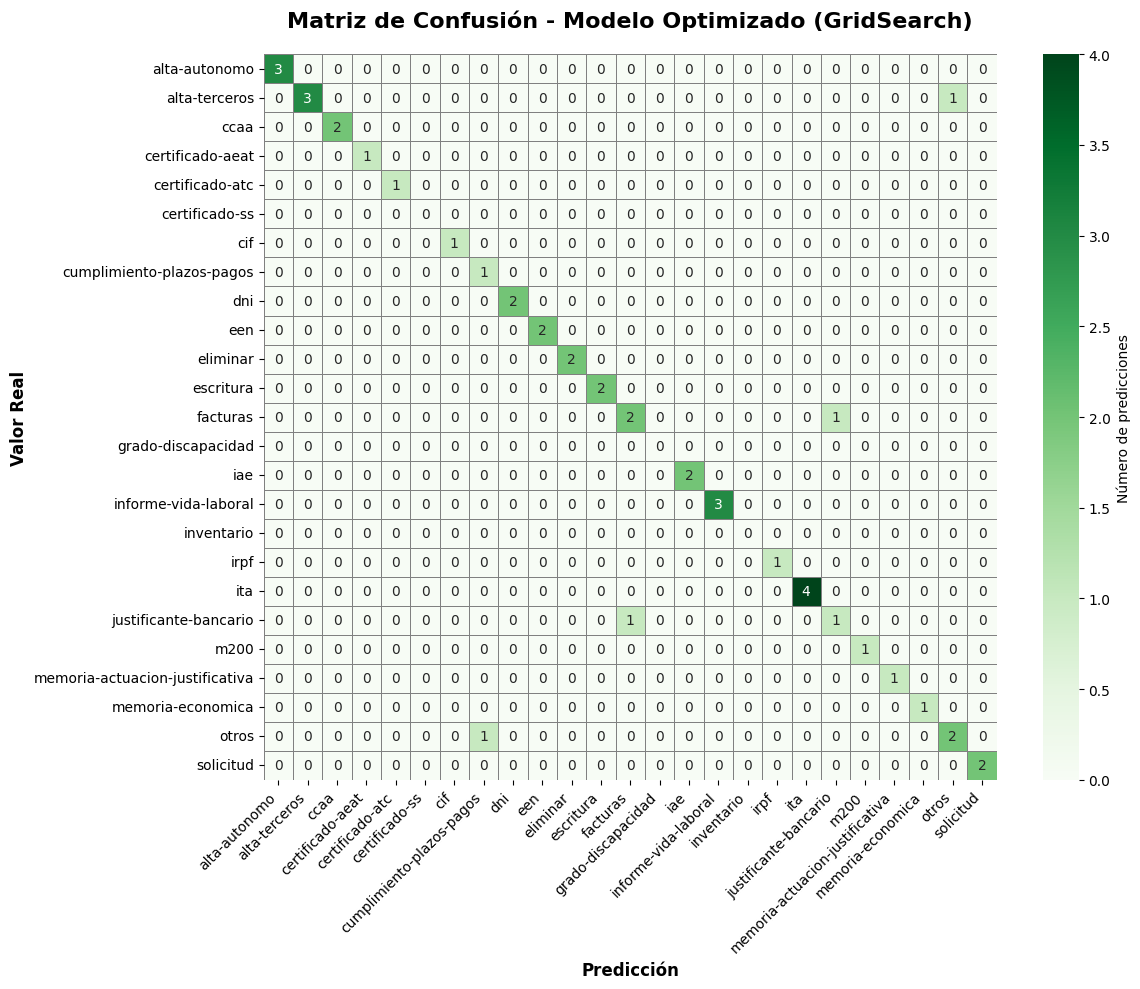


📈 COMPARACIÓN: MODELO BASE vs MODELO OPTIMIZADO

Modelo Base:
  Accuracy:  0.9091
  F1-macro:  0.9253

Modelo Optimizado:
  Accuracy:  0.9091
  F1-macro:  0.9253

Mejora:
  Accuracy:  0.0000 (+0.0%)
  F1-macro:  0.0000 (+0.0%)


In [7]:
# Optimización del modelo mediante GridSearchCV (adaptado para múltiples clases)
pipeline_gs = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, strip_accents="unicode")),
    ("svm", SVC(
        kernel="linear", 
        class_weight="balanced", 
        probability=True,
        decision_function_shape='ovr'
    ))
])

# Espacio de búsqueda de hiperparámetros
param_grid = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__max_features": [5_000, 10_000, 20_000],
    "svm__C": [0.1, 1.0, 5.0]
}

# Configurar GridSearchCV
grid = GridSearchCV(
    estimator=pipeline_gs,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

print("="*70)
print("🔍 BÚSQUEDA DE HIPERPARÁMETROS (GridSearchCV)")
print("="*70)
print(f"Combinaciones a probar: {len(param_grid['tfidf__ngram_range']) * len(param_grid['tfidf__max_features']) * len(param_grid['svm__C'])}")
print(f"Validación cruzada: 5 folds")
print("\nIniciando búsqueda...")

# Entrenamiento sobre el conjunto de entrenamiento
grid.fit(train_df["texto"], train_df["etiqueta"])

# Obtener el mejor modelo
best_model = grid.best_estimator_

# Evaluación en conjunto de validación
y_val_grid = val_df["etiqueta"]
y_pred_grid = best_model.predict(val_df["texto"])

# Resultados
print("\n" + "="*70)
print("✅ MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*70)
for param, valor in grid.best_params_.items():
    print(f"  {param}: {valor}")

print(f"\nMejor score F1-macro (CV): {grid.best_score_:.4f}")

print("\n" + "="*70)
print("📊 RESULTADOS EN VALIDACIÓN (MODELO OPTIMIZADO)")
print("="*70)
print(classification_report(y_val_grid, y_pred_grid, zero_division=0))

# Visualización gráfica de la matriz de confusión para el modelo optimizado
if len(val_df) >= 10:
    cm_grid = confusion_matrix(y_val_grid, y_pred_grid, labels=best_model.classes_)
    
    # Crear figura
    plt.figure(figsize=(12, 10))
    
    # Crear heatmap
    sns.heatmap(
        cm_grid, 
        annot=True,
        fmt='d',
        cmap='Greens',  # Color diferente para distinguir del modelo base
        xticklabels=best_model.classes_,
        yticklabels=best_model.classes_,
        cbar_kws={'label': 'Número de predicciones'},
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title('Matriz de Confusión - Modelo Optimizado (GridSearch)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicción', fontsize=12, fontweight='bold')
    plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Comparación de rendimiento
print("\n" + "="*70)
print("📈 COMPARACIÓN: MODELO BASE vs MODELO OPTIMIZADO")
print("="*70)

# Métricas del modelo base
acc_base = accuracy_score(y_val, y_pred)
f1_base = f1_score(y_val, y_pred, average='macro', zero_division=0)

# Métricas del modelo optimizado
acc_opt = accuracy_score(y_val_grid, y_pred_grid)
f1_opt = f1_score(y_val_grid, y_pred_grid, average='macro', zero_division=0)

print(f"\nModelo Base:")
print(f"  Accuracy:  {acc_base:.4f}")
print(f"  F1-macro:  {f1_base:.4f}")

print(f"\nModelo Optimizado:")
print(f"  Accuracy:  {acc_opt:.4f}")
print(f"  F1-macro:  {f1_opt:.4f}")

print(f"\nMejora:")
print(f"  Accuracy:  {(acc_opt - acc_base):.4f} ({((acc_opt - acc_base) / acc_base * 100):+.1f}%)")
print(f"  F1-macro:  {(f1_opt - f1_base):.4f} ({((f1_opt - f1_base) / f1_base * 100):+.1f}%)")

In [8]:
# Guardar el mejor modelo entrenado usando config
import joblib

modelo_dir = config.MODELO_DIR
os.makedirs(modelo_dir, exist_ok=True)

output_path = config.MODELO_PKL_PATH
joblib.dump(best_model, output_path)

# Guardar también información sobre las clases
clases_info = {
    'clases': list(best_model.classes_),
    'fecha_entrenamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_documentos': len(df),
    'distribucion_clases': df['etiqueta'].value_counts().to_dict(),
    'ruta_datos': str(config.DOCUMENTOS_TXT_DIR.relative_to(config.ROOT_DIR))
}

info_path = config.MODELO_INFO_PATH
joblib.dump(clases_info, info_path)

# Verificación
if os.path.exists(output_path):
    print(f"✅ Modelo guardado correctamente en:")
    print(f"   {output_path.relative_to(project_root)}")
    print(f"✅ Información del modelo guardada en:")
    print(f"   {info_path.relative_to(project_root)}")
    
    # Mostrar información del modelo
    print(f"\n📊 Información del modelo:")
    print(f"  Clases entrenadas: {clases_info['clases']}")
    print(f"  Total documentos: {clases_info['total_documentos']}")
    print(f"  Fecha entrenamiento: {clases_info['fecha_entrenamiento']}")
    print(f"  Ruta datos (relativa): {clases_info['ruta_datos']}")
else:
    print("❌ Error: no se pudo guardar el modelo.")


✅ Modelo guardado correctamente en:
   entrenamiento\model\ClasificadorDocumentos.pkl
✅ Información del modelo guardada en:
   entrenamiento\model\info_modelo.pkl

📊 Información del modelo:
  Clases entrenadas: ['alta-autonomo', 'alta-terceros', 'ccaa', 'certificado-aeat', 'certificado-atc', 'certificado-ss', 'cif', 'cumplimiento-plazos-pagos', 'dni', 'een', 'eliminar', 'escritura', 'facturas', 'grado-discapacidad', 'iae', 'informe-vida-laboral', 'inventario', 'irpf', 'ita', 'justificante-bancario', 'm200', 'memoria-actuacion-justificativa', 'memoria-economica', 'otros', 'solicitud']
  Total documentos: 293
  Fecha entrenamiento: 2025-11-14 10:43:18
  Ruta datos (relativa): datos\documentos-txt


In [ ]:
# Función para hacer predicciones con nuevos documentos (usando config)
def predecir_documento(modelo_path=None, documento_texto=None, documento_archivo=None):
    """
    Realiza predicción sobre un nuevo documento.
    
    Args:
        modelo_path: Ruta al modelo guardado (por defecto usa config)
        documento_texto (str): Texto directo para predecir
        documento_archivo (str): Ruta a archivo para predecir
    
    Returns:
        dict: Diccionario con la predicción y probabilidades
    """
    # Usar ruta de configuración si no se especifica
    if modelo_path is None:
        modelo_path = config.MODELO_PKL_PATH
    
    # Cargar el modelo
    pipeline = joblib.load(modelo_path)
    
    # Obtener el texto
    if documento_archivo:
        with open(documento_archivo, 'r', encoding='utf-8', errors='ignore') as f:
            texto = f.read().strip()
        nombre_archivo = os.path.basename(documento_archivo)
    elif documento_texto:
        texto = documento_texto
        nombre_archivo = "texto_directo"
    else:
        raise ValueError("Debe proporcionar documento_texto o documento_archivo")
    
    if not texto:
        return {"error": "El documento está vacío"}
    
    # Realizar predicción
    etiqueta_predicha = pipeline.predict([texto])[0]
    probabilidades = pipeline.predict_proba([texto])[0]
    
    # Crear diccionario de probabilidades por clase
    clases = pipeline.classes_
    prob_dict = {clase: prob for clase, prob in zip(clases, probabilidades)}
    
    return {
        "archivo": nombre_archivo,
        "texto_length": len(texto),
        "etiqueta_predicha": etiqueta_predicha,
        "confianza": max(probabilidades),
        "probabilidades_por_clase": prob_dict
    }

def listar_archivos_disponibles():
    """
    Lista todos los archivos disponibles en las carpetas de datos para elegir.
    
    Returns:
        list: Lista de tuplas (ruta_completa, ruta_relativa, clase)
    """
    archivos_disponibles = []
    
    for clase in clases_disponibles:
        clase_path = os.path.join(base_dir, clase)
        archivos_clase = glob.glob(os.path.join(clase_path, "*.txt"))
        # Filtrar archivos README
        archivos_clase = [f for f in archivos_clase if not os.path.basename(f).upper().startswith('README')]
        
        for archivo in archivos_clase:
            ruta_relativa = os.path.relpath(archivo, project_root)
            archivos_disponibles.append((archivo, ruta_relativa, clase))
    
    return archivos_disponibles

def mostrar_menu_archivos():
    """
    Muestra un menú para seleccionar archivo y devuelve la ruta seleccionada.
    
    Returns:
        str or None: Ruta del archivo seleccionado o None si se cancela
    """
    archivos = listar_archivos_disponibles()
    
    if not archivos:
        print("No se encontraron archivos para predecir.")
        return None
    
    print("\n" + "="*70)
    print("ARCHIVOS DISPONIBLES PARA PREDICCIÓN")
    print("="*70)
    
    # Agrupar por clase para mejor visualización
    archivos_por_clase = {}
    for archivo_path, ruta_rel, clase in archivos:
        if clase not in archivos_por_clase:
            archivos_por_clase[clase] = []
        archivos_por_clase[clase].append((archivo_path, ruta_rel))
    
    contador = 1
    opciones = {}
    
    for clase in sorted(archivos_por_clase.keys()):
        print(f"\n📁 Clase: {clase.upper()}")
        print("-" * 50)
        
        for archivo_path, ruta_rel in archivos_por_clase[clase]:
            nombre_archivo = os.path.basename(archivo_path)
            print(f"  {contador:2d}. {nombre_archivo}")
            print(f"      📂 {ruta_rel}")
            opciones[contador] = archivo_path
            contador += 1
    
    print(f"\n   0. ❌ Cancelar")
    print("="*70)
    
    while True:
        try:
            seleccion = input(f"\nSelecciona un archivo (0-{contador-1}): ").strip()
            
            if seleccion == "0":
                print("Operación cancelada.")
                return None
            
            seleccion = int(seleccion)
            
            if seleccion in opciones:
                archivo_seleccionado = opciones[seleccion]
                nombre = os.path.basename(archivo_seleccionado)
                print(f"\n✅ Archivo seleccionado: {nombre}")
                return archivo_seleccionado
            else:
                print(f"❌ Por favor, introduce un número entre 0 y {contador-1}")
                
        except ValueError:
            print("❌ Por favor, introduce un número válido")
        except KeyboardInterrupt:
            print("\n\nOperación cancelada por el usuario.")
            return None

# Verificar que el modelo existe
modelo_path = config.MODELO_PKL_PATH

if not os.path.exists(modelo_path):
    print(f"❌ El modelo no existe en: {modelo_path.relative_to(project_root)}")
    print("Primero entrena el modelo ejecutando las celdas anteriores.")
else:
    print("✅ Modelo encontrado. Listo para hacer predicciones.")
    
    # Mostrar opciones al usuario
    print("\n" + "="*70)
    print("OPCIONES DE PREDICCIÓN")
    print("="*70)
    print("1. 📁 Seleccionar archivo de las carpetas de datos")
    print("2. ✏️  Introducir texto directamente")
    print("3. 📂 Especificar ruta de archivo personalizada")
    print("4. ❌ No hacer predicción")
    
    while True:
        try:
            opcion = input("\nSelecciona una opción (1-4): ").strip()
            
            if opcion == "1":
                # Seleccionar de archivos disponibles
                archivo_seleccionado = mostrar_menu_archivos()
                if archivo_seleccionado:
                    resultado = predecir_documento(documento_archivo=archivo_seleccionado)
                    break
                else:
                    continue
                    
            elif opcion == "2":
                # Introducir texto directamente
                print("\n" + "="*50)
                print("INTRODUCIR TEXTO PARA PREDICCIÓN")
                print("="*50)
                print("Introduce el texto a clasificar (termina con una línea vacía):")
                
                lineas = []
                while True:
                    linea = input()
                    if linea.strip() == "":
                        break
                    lineas.append(linea)
                
                texto_usuario = "\n".join(lineas)
                if texto_usuario.strip():
                    resultado = predecir_documento(documento_texto=texto_usuario)
                    break
                else:
                    print("❌ No se introdujo texto. Inténtalo de nuevo.")
                    continue
                    
            elif opcion == "3":
                # Ruta personalizada
                print("\n" + "="*50)
                print("ARCHIVO PERSONALIZADO")
                print("="*50)
                ruta_personalizada = input("Introduce la ruta del archivo: ").strip()
                
                if os.path.exists(ruta_personalizada):
                    resultado = predecir_documento(documento_archivo=ruta_personalizada)
                    break
                else:
                    print(f"❌ El archivo no existe: {ruta_personalizada}")
                    continue
                    
            elif opcion == "4":
                print("❌ No se realizará predicción.")
                resultado = None
                break
                
            else:
                print("❌ Por favor, selecciona una opción válida (1-4)")
                
        except KeyboardInterrupt:
            print("\n\nOperación cancelada por el usuario.")
            resultado = None
            break
    
    # Mostrar resultados si se hizo predicción
    if resultado and "error" not in resultado:
        print("\n" + "="*70)
        print("🎯 RESULTADO DE LA PREDICCIÓN")
        print("="*70)
        print(f"📄 Archivo: {resultado['archivo']}")
        print(f"📊 Longitud del texto: {resultado['texto_length']} caracteres")
        print(f"🏷️  Etiqueta predicha: {resultado['etiqueta_predicha']}")
        print(f"🎯 Confianza: {resultado['confianza']:.3f} ({resultado['confianza']*100:.1f}%)")
        
        print(f"\n📈 Probabilidades por clase:")
        probabilidades_ordenadas = sorted(resultado['probabilidades_por_clase'].items(), 
                                        key=lambda x: x[1], reverse=True)
        
        for clase, prob in probabilidades_ordenadas:
            barra = "█" * int(prob * 20)  # Barra visual de 20 caracteres máximo
            print(f"  {clase:<12}: {prob:.3f} ({prob*100:5.1f}%) {barra}")
        
        print("="*70)
        
    elif resultado and "error" in resultado:
        print(f"\n❌ Error: {resultado['error']}")


🤖 Modelo encontrado. Listo para hacer predicciones.

OPCIONES DE PREDICCIÓN
1. 📁 Seleccionar archivo de las carpetas de datos
2. ✏️  Introducir texto directamente
3. 📂 Especificar ruta de archivo personalizada
4. ❌ No hacer predicción



ARCHIVO PERSONALIZADO

🎯 RESULTADO DE LA PREDICCIÓN
📄 Archivo: Justificante_E_1895131_EICA_62148_02102025_124915_02102025_124915.txt
📊 Longitud del texto: 1869 caracteres
🏷️  Etiqueta predicha: RegistroEntrada
🎯 Confianza: 0.712 (71.2%)

📈 Probabilidades por clase:
  RegistroEntrada: 0.712 ( 71.2%) ██████████████
  RegistroSalida: 0.102 ( 10.2%) ██
  Otros       : 0.056 (  5.6%) █
  6488-4196   : 0.036 (  3.6%) 
  SolicitudDigital: 0.030 (  3.0%) 
  Metadatos   : 0.029 (  2.9%) 
  RegistroGeneral: 0.019 (  1.9%) 
  ComprobanteRegistro: 0.014 (  1.4%) 
